In [1]:
import pandas as pd
import keras
import os
from data_loading import load_tracking_data
from sklearn.pipeline import Pipeline
from lightgbm import LGBMClassifier
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from scipy import spatial
import numpy as np
from keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score

from utility_db_25 import mark_columns, TrainML
from utility_db_25 import mark_columns, TrainML, get_momentum_cols, create_momentum_index, get_motion_cols, motion_complexity_score
root_dir = os.getcwd()

# Load data

We first load our data, starting with tracking & general player data

In [2]:
# load tracking data for all weeks
root_dir = os.getcwd()
tracking_fname_list = [os.path.join(root_dir,  f"data/tracking_week_{i}.csv") for i in range(1,10)]
df_tracking = pd.concat(
        [load_tracking_data(tracking_fname) for tracking_fname in tracking_fname_list]
    )

# get players data
df_players = pd.read_csv(os.path.join(root_dir,'data/players.csv'))
df_players.loc[df_players['nflId'] ==45244, 'position'] = 'TE' #update data for Taysom Hill

# load tracking, truncate to relevant columns, delete
cols_track = ['gameId','playId','event','nflId','frameId','club','x_standard','y_standard', 'dis', 'dir_standard']
track_trunc = df_tracking[cols_track]
del(df_tracking)

In [3]:
track_trunc.to_csv('data/tracking_trunc.csv')

In [4]:
#track_trunc=pd.read_csv('data/tracking_trunc.csv')
df_games = pd.read_csv('data/games.csv')[[
    'gameId','week'
]].drop_duplicates()
track_trunc=pd.merge(track_trunc, df_games, on='gameId', how='inner')

### Merge onto play level

Note: some plays (38?) lack defensive tracking data, ergo losing some plays to dropping NA's 


In [5]:
# merge  tracking info to play-level data
df_plays = pd.read_csv(os.path.join(root_dir,'data/plays.csv'))
play_trunc = df_plays[['gameId','playId','possessionTeam','isDropback']]
track_trunc['event'].fillna('NONE', inplace=True)
pt_df = pd.merge(track_trunc,play_trunc, how='left',right_on=['gameId','playId','possessionTeam'],
                 left_on=['gameId','playId','club'])

# na's dropped to lose players w/o tracking info
def_df = pt_df.dropna().copy()
def_df.head(3)

,gameId,playId,event,nflId,frameId,club,x_standard,y_standard,dis,dir_standard,week,possessionTeam,isDropback
112,2022091200,64,NONE,39987.0,2,SEA,33.95,23.50,0.04,19.89,1,SEA,False
113,2022091200,64,NONE,39987.0,3,SEA,33.96,23.54,0.04,19.91,1,SEA,False
114,2022091200,64,NONE,39987.0,4,SEA,33.98,23.58,0.05,24.17,1,SEA,False


In [6]:
# get position here for calcs

def_temp = def_df.merge(df_players[['nflId','position']],how='left',copy=False)
def_temp.sort_values(by=['gameId','playId','frameId'],inplace=True)
del(track_trunc)
del(df_players)
def_temp.head()
def_temp.drop(columns='week', inplace=True)

In [7]:

ci = pd.merge(def_temp[['gameId','playId']].drop_duplicates(), pd.Series(list(range(1,76))).rename('frameId'), how='cross',copy=False).sort_values(by=['gameId','playId','frameId'])
ci=pd.merge(df_games, ci, on=['gameId'])[['gameId', 'playId', 'frameId', 'week']]
ci_merged = pd.merge(ci, def_temp,on=['gameId', 'playId', 'frameId'],how='left',copy=False)[['gameId', 'playId', 'frameId', 'week']].drop_duplicates()

In [8]:
len(ci)

1206450

In [9]:
len(def_temp)

18371122

In [10]:
len(ci_merged)


1206450

In [11]:
def get_event_frame(df, event_name):
    grouped_df=df[df['event']==event_name][['gameId', 'playId', 'frameId']].groupby(by=['gameId', 'playId']).max().reset_index()
    grouped_df.columns=['gameId', 'playId', event_name+'_frameId']
    df=pd.merge(df, grouped_df,on=['gameId', 'playId'], how='left')
    return df

In [12]:
def_temp=get_event_frame(def_temp, 'line_set')
def_temp['motion_after_lineset']=np.where(((def_temp['frameId']>def_temp['line_set_frameId']) & (def_temp['event']=='man_in_motion')), 1, 0).astype(float)
def_temp['motion_']=np.where((def_temp['event']=='man_in_motion'), 1, 0).astype(float)



In [13]:
off_positions=['WR','T','G', 'TE',  'RB','FB', 'C', 'QB']
for p in off_positions:
    df=def_temp[def_temp['position']==p][['gameId', 'playId', 'frameId','dir_standard', 'dis', 'x_standard', 'y_standard', 'motion_after_lineset', 'motion_']].groupby(['gameId', 'playId', 'frameId']).agg({'dir_standard': 'mean', 'dis':'sum', 'x_standard':'mean', 'y_standard':'mean', 'motion_after_lineset':'sum', 'motion_':'sum'}).reset_index().copy()
    df.columns = ['gameId', 'playId', 'frameId',p+'_dir', p+'_dis', p+'x_standard', p+'y_standard', p+'motion_after_lineset', p+'motion']
    ci_merged=pd.merge(ci_merged,df,how='left',on=['gameId','playId','frameId'])
    del(df)
ci_merged.fillna(0, inplace=True)

In [14]:
ci_merged['motion_after_lineset']=ci_merged[['Tmotion_after_lineset', 'Gmotion_after_lineset', 'TEmotion_after_lineset',  'FBmotion_after_lineset', 'Cmotion_after_lineset', 'QBmotion_after_lineset']].sum(axis=1)
ci_merged['motion']=ci_merged[['Tmotion', 'Gmotion', 'TEmotion',  'FBmotion', 'Cmotion', 'QBmotion']].sum(axis=1)
ci_merged.head()

,gameId,playId,frameId,week,WR_dir,WR_dis,WRx_standard,WRy_standard,WRmotion_after_lineset,WRmotion,...,Cmotion_after_lineset,Cmotion,QB_dir,QB_dis,QBx_standard,QBy_standard,QBmotion_after_lineset,QBmotion,motion_after_lineset,motion
0,2022090800,56,1,1,0.000000,0.00,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.00,0.00,0.00,0.000000,0.0,0.0,0.0,0.0
1,2022090800,56,2,1,123.513333,0.79,28.726667,24.876667,0.0,0.0,...,0.0,0.0,276.39,0.03,29.09,24.003333,0.0,0.0,0.0,0.0
2,2022090800,56,3,1,123.550000,0.82,28.730000,25.143333,0.0,0.0,...,0.0,0.0,270.41,0.04,29.06,23.983333,0.0,0.0,0.0,0.0
3,2022090800,56,4,1,124.723333,0.84,28.743333,25.423333,0.0,0.0,...,0.0,0.0,259.93,0.06,29.01,23.943333,0.0,0.0,0.0,0.0
4,2022090800,56,5,1,126.343333,0.84,28.763333,25.700000,0.0,0.0,...,0.0,0.0,255.77,0.04,28.98,23.923333,0.0,0.0,0.0,0.0


In [15]:

def calculate_distance(row):
    x1, y1 = row['RBx_standard'], row['RBy_standard']
    x2, y2 = row['QBx_standard'], row['QBy_standard']
    return np.sqrt((x2 - x1)**2 + (y2 - y1)**2)


ci_merged['RBdistance'] = ci_merged.apply(calculate_distance, axis=1)

def calculate_distance(row):
    x1, y1 = row['Gx_standard'], row['Gy_standard']
    x2, y2 = row['QBx_standard'], row['QBy_standard']
    return np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
ci_merged['Gdistance'] = ci_merged.apply(calculate_distance, axis=1)


def calculate_distance(row):
    x1, y1 = row['Cx_standard'], row['Cy_standard']
    x2, y2 = row['QBx_standard'], row['QBy_standard']
    return np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
ci_merged['Cdistance'] = ci_merged.apply(calculate_distance, axis=1)
def calculate_distance(row):
    x1, y1 = row['TEx_standard'], row['TEy_standard']
    x2, y2 = row['QBx_standard'], row['QBy_standard']
    return np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
ci_merged['TEdistance'] = ci_merged.apply(calculate_distance, axis=1)
def calculate_distance(row):
    x1, y1 = row['Tx_standard'], row['Ty_standard']
    x2, y2 = row['QBx_standard'], row['QBy_standard']
    return np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
ci_merged['Tdistance'] = ci_merged.apply(calculate_distance, axis=1)


In [16]:
# merge back in

db_df = def_df[['gameId','playId','isDropback']].drop_duplicates()
ci_pre = ci_merged.merge(db_df,how='left')
del(ci_merged)
#del(def_df)
ci_pre=ci_pre[ci_pre['week']>0]

In [17]:
len(ci_pre)/75

16086.0

In [18]:
len(db_df)

16086

### Perform train/test split

We integrate week data, then subset based on week 9 holdout:

In [19]:
# subset week
df_train = ci_pre[(ci_pre['week'] <5.0) ].drop_duplicates()
df_val = ci_pre[((ci_pre['week'] >=5.0)& (ci_pre['week']<9.0)) ].drop_duplicates()
df_test = ci_pre[ci_pre['week'] ==9.0].drop_duplicates()

# y = isDropback
y_train = df_train['isDropback'].astype(int)
y_val = df_val['isDropback'].astype(int)
y_test = df_test['isDropback'].astype(int)

In [20]:
time_features=['Tmotion', 'Gmotion', 'TEmotion',  'FBmotion', 'Cmotion', 'QBmotion','RBdistance','Gdistance','TEdistance', 'Tdistance','TEx_standard', 'TEy_standard','Cx_standard',
       'Cy_standard' , 'RBy_standard']
static_features=['xpass_situational', 'yardsToGo', 'down',  'neg_alignment','absoluteYardlineNumber','time_remaining','quarter',
 'neg_Formations',
 'off_xpass',
 'QBdffy_RB',
 'presnap_motion_complexity',
 'presnap_momentum',
 'receiverAlignment_3x2', 
 'QBdff_WR']

In [21]:
# define scaler
scaler = MinMaxScaler(feature_range=(0, 1))

# scale
df_train[time_features] = scaler.fit_transform(df_train[time_features].values.reshape(-1, len(time_features)))
df_val[time_features] = scaler.fit_transform(df_val[time_features].values.reshape(-1, len(time_features)))
df_test[time_features] = scaler.transform(df_test[time_features].values.reshape(-1, len(time_features)))



In [22]:
# reshape
X_train = df_train[time_features].to_numpy().reshape(int(len(df_train)/75), 75, len(time_features))
X_val = df_val[time_features].to_numpy().reshape(int(len(df_val)/75), 75, len(time_features))
X_test = df_test[time_features].to_numpy().reshape(int(len(df_test)/75), 75, len(time_features))

y_train = df_train.drop_duplicates(subset=['gameId','playId'])['isDropback'].astype(int)
y_test = df_test.drop_duplicates(subset=['gameId','playId'])['isDropback'].astype(int)

In [23]:
df_train.fillna(0, inplace=True)
df_val.fillna(0, inplace=True)

In [24]:
# Define model architecture

def create_RNN():
    model = keras.models.Sequential()
    model.add(keras.layers.Masking(mask_value=0.))
    model.add(keras.layers.LSTM(128))
    model.add(Dense(32, activation='tanh'))
    model.add(Dropout(.005))
    model.add(Dense(8, activation='tanh'))
    model.add(Dropout(.005))
    model.add(Dense(8, activation='tanh'))
    model.add(Dense(1, activation='sigmoid'))
    optimizer = keras.optimizers.Adam(.004)

    return model
demo_model = create_RNN()
demo_model.compile(loss='binary_crossentropy')
demo_model.fit(X_train,y_train,epochs=20)
y_pred = (demo_model.predict(X_test) > .5)
sum(y_test == y_pred.reshape(-1))/len(y_test)

Epoch 1/20
236/236 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - loss: 0.6707
Epoch 2/20
236/236 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.6252
Epoch 3/20
236/236 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - loss: 0.5972
Epoch 4/20
236/236 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.6055
Epoch 5/20
236/236 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - loss: 0.5972
Epoch 6/20
236/236 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.5867
Epoch 7/20
236/236 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.5886
Epoch 8/20
236/236 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.5813
Epoch 9/20
236/236 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - loss: 0.5758
Epoch 10/20
236/236 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.5796
Epoch 11/20
236/236 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.5846
Epoch 12/20
236/236 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - loss: 0.5810
Epoch 13/20
236/236 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - loss: 0.5776
Epoch 14/20
236/236 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - loss: 0.5806
Epoch 15/20
236/236 ━━━━━━━━━━━━━━━━━━━━ 6s

0.6431372549019608

In [25]:
# load original data
train_data=pd.read_csv(os.path.join(root_dir, "data/train_data.csv"))
test_data=pd.read_csv(os.path.join(root_dir, "data/test_data.csv"))
train_motion_cols=get_motion_cols(train_data.columns)
train_momentum_cols=get_momentum_cols(train_data.columns)

test_motion_cols=get_motion_cols(test_data.columns)
test_momentum_cols=get_momentum_cols(test_data.columns)


train_data=create_momentum_index(train_data, train_momentum_cols)
test_data=create_momentum_index(test_data, test_momentum_cols)

train_data=motion_complexity_score(train_data, test_motion_cols)
test_data=motion_complexity_score(test_data, test_motion_cols)


In [26]:
val_games=df_val[['gameId', 'playId']].drop_duplicates()
val_data=pd.merge(train_data[['gameId', 'playId','yardsToGo', 'down',  'neg_alignment','absoluteYardlineNumber','time_remaining','quarter',
 'neg_Formations',
 'off_xpass',
 'QBdffy_RB',
 'presnap_motion_complexity',
 'presnap_momentum',
 'receiverAlignment_3x2', 
 'QBdff_WR','pass']], val_games, on=['gameId', 'playId'], how='inner')


In [27]:
val_data

,gameId,playId,yardsToGo,down,neg_alignment,absoluteYardlineNumber,time_remaining,quarter,neg_Formations,off_xpass,QBdffy_RB,presnap_motion_complexity,presnap_momentum,receiverAlignment_3x2,QBdff_WR,pass
0,2022100600,56,10,1,0,85,60.000000,1,0,0.651983,16.064205,0.0,0.0,0,84.988138,1
1,2022100600,90,10,2,0,85,59.950000,1,0,0.644997,15.673800,0.0,0.0,0,95.567678,0
2,2022100600,111,7,3,0,82,59.216667,1,0,0.661729,15.581881,0.0,0.0,0,77.643718,1
3,2022100600,157,10,1,0,46,58.616667,1,0,0.566020,16.017198,0.0,0.0,0,93.319890,0
4,2022100600,178,7,2,0,49,58.266667,1,0,0.566020,12.890937,0.0,0.0,0,141.969875,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7021,2022103100,3596,9,2,0,45,3.316667,4,1,0.568401,11.893793,0.0,0.0,0,89.336161,0
7022,2022103100,3674,5,1,1,28,2.366667,4,1,0.564558,11.812542,0.0,0.0,0,128.143625,0
7023,2022103100,3697,1,2,1,24,2.000000,4,1,0.564558,14.819406,0.0,0.0,0,88.361644,0
7024,2022103100,3727,10,1,0,20,1.266667,4,0,0.609726,14.010394,0.0,0.0,0,114.712327,0


In [28]:
val_data['RNN']=(demo_model.predict(X_val) > .5).reshape(-1)
test_data['RNN']=(demo_model.predict(X_test) > .5).reshape(-1)

220/220 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


In [32]:
static_features.remove('xpass_situational')

In [29]:
static_features.append('RNN')

In [33]:
final_features=static_features

In [34]:
X_val=val_data[final_features].fillna(0)
X_test=test_data[final_features].fillna(0)
y_val=val_data['pass']
y_test=test_data['pass']

Training Folds: 100%|██████████| 5/5 [00:00<00:00, 12.56it/s]


Mean Train AUC --> 0.8722
Mean Validation AUC ---> 0.7730
Mean Train Accuracy --> 0.8791
Mean Validation Accuracy ---> 0.7862


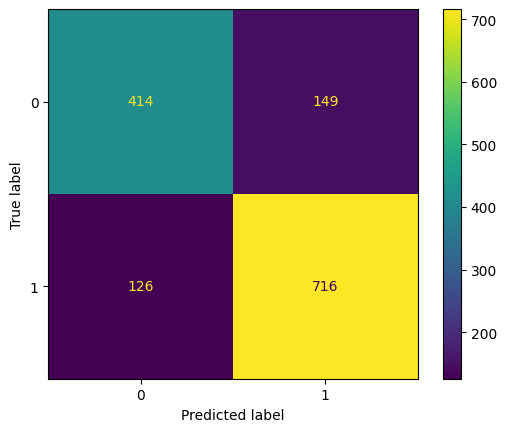

In [35]:

lgb = LGBMClassifier(verbosity=-1,seed=42).fit(X_val,y_val)
TrainML(lgb,X_val, y_val,5,SEED=42)

c:\ProgramData\Anaconda3\envs\bdb2025-env\lib\site-packages\shap\explainers\_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


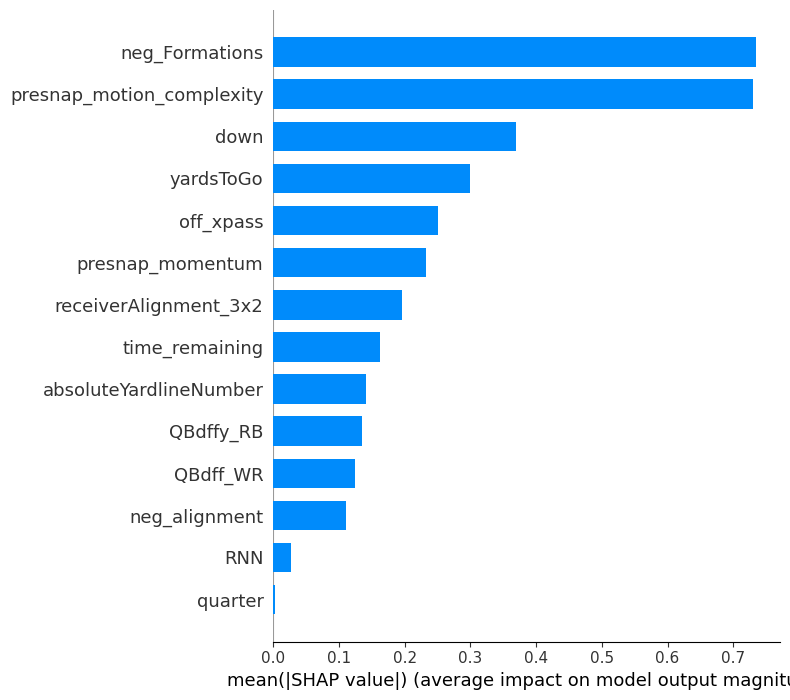

In [36]:
import shap 
shap_values = shap.TreeExplainer(lgb).shap_values(X_test[final_features])
shap.summary_plot(shap_values, X_test, plot_type="bar")
feature_names = final_features


lgbm_resultX = pd.DataFrame(shap_values, columns = feature_names)

vals = np.abs(lgbm_resultX.values).mean(0)

shap_importance = pd.DataFrame(list(zip(feature_names, vals)),
                                  columns=['col_name','feature_importance_vals'])
shap_importance.sort_values(by=['feature_importance_vals'],
                               ascending=False, inplace=True)


In [37]:
y_pred=lgb.predict(X_test[final_features])
accuracy_score(y_test, y_pred)

0.8117647058823529